### 1. Load Dataset

In [2]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/home/santanu/code/sjchem/bank-account-fraud-detection/raw_data/Base.csv')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

### Modeling and Baselines
Building a strong, leakage-safe baseline fraud model, evaluate it with fraud-appropriate metrics
1st target is feature engineering


### Pipeline Architecture
Raw Data
  ↓
Train / Validation Split (time-aware)
  ↓
Feature Selection (locked list)
  ↓
Preprocessing
  ├── LightGBM path (native categorical)
  └── XGBoost path (encoded categorical)
  ↓
Model Training
  ↓
Evaluation (same metrics)


### 2. Train / Validation Split

#### 2.1 Feature Lists

In [5]:
TARGET = 'fraud_bool'
NUM_COLS =  [
    'income','customer_age','credit_risk_score',
    'proposed_credit_limit','intended_balcon_amount',
    'session_length_in_minutes','days_since_request',
    'bank_months_count','zip_count_4w',
    'velocity_6h','velocity_24h','velocity_4w',
    'bank_branch_count_8w','device_distinct_emails_8w',
    'date_of_birth_distinct_emails_4w',
    'current_address_months_count','prev_address_months_count'
]
BIN_COLS = [
    'email_is_free','phone_home_valid','phone_mobile_valid',
    'has_other_cards','foreign_request','keep_alive_session'
]
CAT_COLS =[
    'employment_status','housing_status','payment_type',
    'source','device_os','month'
]
# Create interaction features
df['income_per_age'] = df['income'] / (df['customer_age'] + 1)
df['credit_utilization'] = df['intended_balcon_amount'] / (df['proposed_credit_limit'] + 1)
df['velocity_ratio'] = df['velocity_6h'] / (df['velocity_4w'] + 1)
df['avg_velocity_per_hour'] = df['velocity_24h'] / 24
NUM_COLS += ['income_per_age', 'credit_utilization', 'velocity_ratio', 'avg_velocity_per_hour']
FEATURES = NUM_COLS + BIN_COLS + CAT_COLS

In [6]:
### Trai / Validation Split
train_df = df[df['month'] <= 6]
valid_df = df[df['month'] > 6]


In [7]:
X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_valid = valid_df[FEATURES]
y_valid = valid_df[TARGET]


#### 2.2 Light GBM Pipeline

In [8]:
for c in CAT_COLS:
    X_train[c] = X_train[c].astype('category')
    X_valid[c] = X_valid[c].astype('category')

/tmp/ipykernel_27726/2017687960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[c] = X_train[c].astype('category')
/tmp/ipykernel_27726/2017687960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[c] = X_valid[c].astype('category')
/tmp/ipykernel_27726/2017687960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [9]:
import lightgbm as lgb

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

params = {
    'objective': 'binary',  # Changed from regression
    'metric': 'auc',  # Changed from rmse - can also use 'binary_logloss'
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,  # Reduced for better convergence
    'num_leaves': 31,  # Reduced to prevent overfitting
    'max_depth': 6,  # Set explicit depth
    'min_data_in_leaf': 50,  # Reduced to capture rare fraud patterns
    'min_child_weight': 5,  # Add regularization
    'feature_fraction': 0.7,  # More aggressive feature sampling
    'bagging_fraction': 0.7,  # More aggressive row sampling
    'bagging_freq': 5,
    'lambda_l1': 0.1,  # L1 regularization
    'lambda_l2': 0.1,  # L2 regularization
    'scale_pos_weight': scale_pos_weight,
    #'is_unbalance': True,  # Explicitly handle imbalance
    'verbosity': -1,
    'seed': 42
}

In [10]:
lgb_train = lgb.Dataset(
    X_train, y_train,
    categorical_feature=CAT_COLS,
    free_raw_data=False
)

lgb_valid = lgb.Dataset(
    X_valid, y_valid,
    categorical_feature=CAT_COLS,
    free_raw_data=False
)


In [11]:
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_valid],  # Only validate on validation set
    num_boost_round=5000,  # Increased rounds
    callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(period=100)],
)


Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.879673
[200]	valid_0's auc: 0.883097
[300]	valid_0's auc: 0.886048
[400]	valid_0's auc: 0.887987
[500]	valid_0's auc: 0.889477
[600]	valid_0's auc: 0.890439
[700]	valid_0's auc: 0.891148
[800]	valid_0's auc: 0.891625
[900]	valid_0's auc: 0.891999
[1000]	valid_0's auc: 0.892112
[1100]	valid_0's auc: 0.892315
[1200]	valid_0's auc: 0.892689
[1300]	valid_0's auc: 0.89267
[1400]	valid_0's auc: 0.892533
Early stopping, best iteration is:
[1258]	valid_0's auc: 0.892735


In [12]:
y_pred = model.predict(X_valid)


In [13]:
# PR-AUC (Primary)
from sklearn.metrics import average_precision_score
ap = average_precision_score(y_valid, y_pred)
print(f"PR-AUC: {ap:.4f}")


PR-AUC: 0.2098


In [14]:
# Recall @ Fixed FPR
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
idx = np.where(fpr <= 0.01)[0][-1]

print("Recall @ 1% FPR:", tpr[idx])

Recall @ 1% FPR: 0.2710084033613445


In [15]:
# recision @ Top-K%
k = int(0.01 * len(y_pred))
top_k_idx = np.argsort(y_pred)[-k:]

precision_at_k = y_valid.iloc[top_k_idx].mean()
print("Precision @ top 1%:", precision_at_k)


Precision @ top 1%: 0.32541322314049587


### 2.2.1 Threshold Selection (VERY IMPORTANT)

Default 0.5 is ❌ wrong.

Choose threshold based on:

Fraud ops capacity

Manual review limits

False positive tolerance

In [16]:
threshold = thresholds[idx]
print("Threshold at 1% FPR:", threshold)


Threshold at 1% FPR: 0.8901460925072603


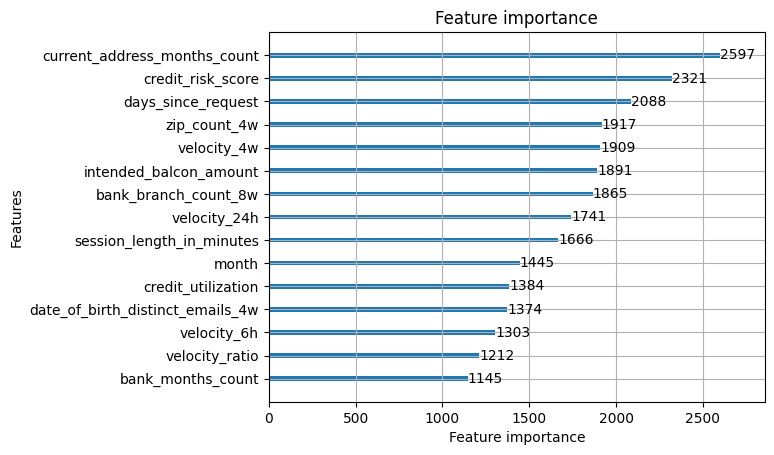

In [17]:
lgb.plot_importance(model, max_num_features=15)
plt.show()

### 2.3 XGBoost Pipeline

In [18]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

X_train_xgb = X_train.copy()
X_valid_xgb = X_valid.copy()

X_train_xgb[CAT_COLS] = encoder.fit_transform(X_train[CAT_COLS])
X_valid_xgb[CAT_COLS] = encoder.transform(X_valid[CAT_COLS])


In [19]:
## Train XGBoost Model
import xgboost as xgb
xgb_model = xgb.XGBClassifier(
    n_estimators=5000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    early_stopping_rounds=200,
    #use_label_encoder=False,
    random_state=42
)

In [20]:
xgb_model.fit(
    X_train_xgb, y_train,
    eval_set=[(X_valid_xgb, y_valid)],
    verbose=True
)

[0]	validation_0-logloss:0.67250
[1]	validation_0-logloss:0.65336
[2]	validation_0-logloss:0.63659
[3]	validation_0-logloss:0.62013
[4]	validation_0-logloss:0.60512
[5]	validation_0-logloss:0.59283
[6]	validation_0-logloss:0.57982
[7]	validation_0-logloss:0.56781
[8]	validation_0-logloss:0.55690
[9]	validation_0-logloss:0.54723
[10]	validation_0-logloss:0.53778
[11]	validation_0-logloss:0.53123
[12]	validation_0-logloss:0.52253
[13]	validation_0-logloss:0.51547
[14]	validation_0-logloss:0.50709
[15]	validation_0-logloss:0.49977
[16]	validation_0-logloss:0.49300
[17]	validation_0-logloss:0.48573
[18]	validation_0-logloss:0.47991
[19]	validation_0-logloss:0.47419
[20]	validation_0-logloss:0.46881
[21]	validation_0-logloss:0.46457
[22]	validation_0-logloss:0.45948
[23]	validation_0-logloss:0.45603
[24]	validation_0-logloss:0.45076
[25]	validation_0-logloss:0.44693
[26]	validation_0-logloss:0.44247
[27]	validation_0-logloss:0.43889
[28]	validation_0-logloss:0.43588
[29]	validation_0-loglos

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,200
,enable_categorical,False
,eval_metric,'logloss'


In [21]:
from sklearn.metrics import average_precision_score

def evaluate_model(y_true, y_pred, name):
    ap = average_precision_score(y_true, y_pred)
    print(f"{name} PR-AUC: {ap:.4f}")


In [22]:
evaluate_model(y_valid, xgb_model.predict_proba(X_valid_xgb)[:, 1], "XGBoost")

XGBoost PR-AUC: 0.1011


In [23]:
import numpy as np
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
idx = np.where(fpr <= 0.01)[0][-1]

print("Recall @ 1% FPR:", tpr[idx])


Recall @ 1% FPR: 0.2710084033613445


In [24]:
k = int(0.01 * len(y_pred))
top_k_idx = np.argsort(y_pred)[-k:]

precision_at_k = y_valid.iloc[top_k_idx].mean()
print("Precision @ top 1%:", precision_at_k)


Precision @ top 1%: 0.32541322314049587


In [25]:
threshold = thresholds[idx]
print("Threshold at 1% FPR:", threshold)

Threshold at 1% FPR: 0.8901460925072603


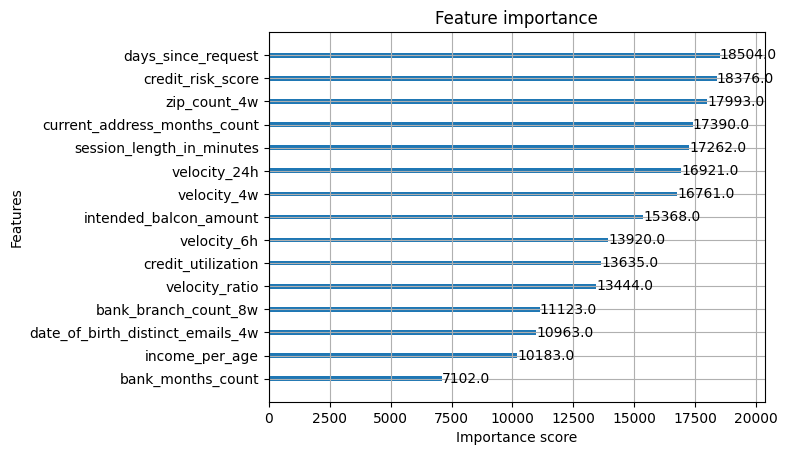

In [26]:
xgb.plot_importance(xgb_model, max_num_features=15)
plt.show()

In [27]:
from sklearn.metrics import average_precision_score, roc_auc_score

# Compare LightGBM and XGBoost models
print("=" * 60)
print("MODEL COMPARISON: LightGBM vs XGBoost")
print("=" * 60)

# Get predictions from both models
lgb_pred = model.predict(X_valid)
xgb_pred = xgb_model.predict_proba(X_valid_xgb)[:, 1]

# Compare PR-AUC

lgb_pr_auc = average_precision_score(y_valid, lgb_pred)
xgb_pr_auc = average_precision_score(y_valid, xgb_pred)

lgb_roc_auc = roc_auc_score(y_valid, lgb_pred)
xgb_roc_auc = roc_auc_score(y_valid, xgb_pred)

print("\n📊 Performance Metrics:")
print(f"{'Metric':<20} {'LightGBM':<15} {'XGBoost':<15} {'Winner':<10}")
print("-" * 60)
print(f"{'PR-AUC':<20} {lgb_pr_auc:<15.4f} {xgb_pr_auc:<15.4f} {'LightGBM' if lgb_pr_auc > xgb_pr_auc else 'XGBoost':<10}")
print(f"{'ROC-AUC':<20} {lgb_roc_auc:<15.4f} {xgb_roc_auc:<15.4f} {'LightGBM' if lgb_roc_auc > xgb_roc_auc else 'XGBoost':<10}")

# Recall at 1% FPR
fpr_lgb, tpr_lgb, _ = roc_curve(y_valid, lgb_pred)
fpr_xgb, tpr_xgb, _ = roc_curve(y_valid, xgb_pred)

idx_lgb = np.where(fpr_lgb <= 0.01)[0][-1]
idx_xgb = np.where(fpr_xgb <= 0.01)[0][-1]

recall_lgb = tpr_lgb[idx_lgb]
recall_xgb = tpr_xgb[idx_xgb]

print(f"{'Recall @ 1% FPR':<20} {recall_lgb:<15.4f} {recall_xgb:<15.4f} {'LightGBM' if recall_lgb > recall_xgb else 'XGBoost':<10}")

# Precision at top 1%
k = int(0.01 * len(y_valid))
top_k_lgb = np.argsort(lgb_pred)[-k:]
top_k_xgb = np.argsort(xgb_pred)[-k:]

prec_lgb = y_valid.iloc[top_k_lgb].mean()
prec_xgb = y_valid.iloc[top_k_xgb].mean()

print(f"{'Precision @ top 1%':<20} {prec_lgb:<15.4f} {prec_xgb:<15.4f} {'LightGBM' if prec_lgb > prec_xgb else 'XGBoost':<10}")

# Model parameters comparison
print("\n⚙️ Model Parameters:")
print(f"{'Parameter':<30} {'LightGBM':<20} {'XGBoost':<20}")
print("-" * 70)
print(f"{'Learning Rate':<30} {params['learning_rate']:<20} {xgb_model.learning_rate:<20}")
print(f"{'Max Depth':<30} {params['max_depth']:<20} {xgb_model.max_depth:<20}")
print(f"{'Num Estimators/Rounds':<30} {model.num_trees():<20} {xgb_model.n_estimators:<20}")
print(f"{'Best Iteration':<30} {model.best_iteration:<20} {xgb_model.best_iteration:<20}")
print(f"{'Feature Sampling':<30} {params['feature_fraction']:<20} {xgb_model.colsample_bytree:<20}")
print(f"{'Row Sampling':<30} {params['bagging_fraction']:<20} {xgb_model.subsample:<20}")
print(f"{'Scale Pos Weight':<30} {params['scale_pos_weight']:<20.2f} {xgb_model.scale_pos_weight:<20.2f}")

print("\n" + "=" * 60)

MODEL COMPARISON: LightGBM vs XGBoost

📊 Performance Metrics:
Metric               LightGBM        XGBoost         Winner    
------------------------------------------------------------
PR-AUC               0.2098          0.1011          LightGBM  
ROC-AUC              0.8927          0.8203          LightGBM  
Recall @ 1% FPR      0.2710          0.1415          LightGBM  
Precision @ top 1%   0.3254          0.1860          LightGBM  

⚙️ Model Parameters:
Parameter                      LightGBM             XGBoost             
----------------------------------------------------------------------
Learning Rate                  0.01                 0.05                
Max Depth                      6                    8                   
Num Estimators/Rounds          1258                 5000                
Best Iteration                 1258                 1414                
Feature Sampling               0.7                  0.8                 
Row Sampling              

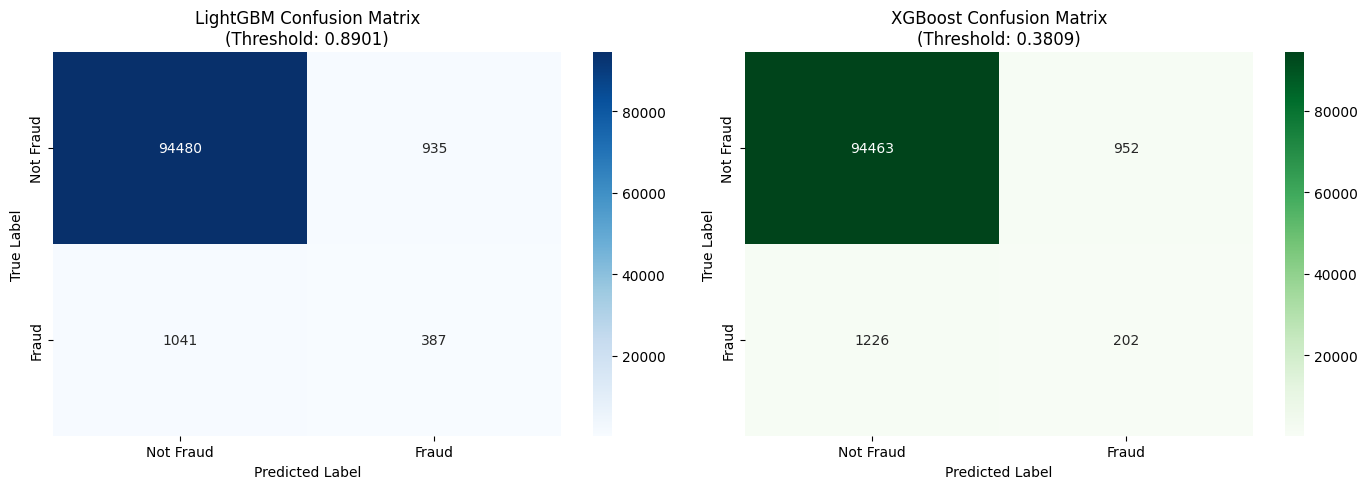

CONFUSION MATRIX ANALYSIS

LightGBM (Threshold: 0.8901):
Metric                    Count     
-----------------------------------
True Negatives (TN)       94,480    
False Positives (FP)      935       
False Negatives (FN)      1,041     
True Positives (TP)       387       
-----------------------------------
Total Predictions         96,843    
Actual Frauds             1,428     
Predicted Frauds          1,322     

False Positive Rate       0.0098    
True Positive Rate        0.2710    
Precision                 0.2927    

XGBoost (Threshold: 0.3809):
Metric                    Count     
-----------------------------------
True Negatives (TN)       94,463    
False Positives (FP)      952       
False Negatives (FN)      1,226     
True Positives (TP)       202       
-----------------------------------
Total Predictions         96,843    
Actual Frauds             1,428     
Predicted Frauds          1,154     

False Positive Rate       0.0100    
True Positive Rate        0

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions at the threshold for 1% FPR
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_valid, lgb_pred)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_valid, xgb_pred)

idx_lgb = np.where(fpr_lgb <= 0.01)[0][-1]
idx_xgb = np.where(fpr_xgb <= 0.01)[0][-1]

threshold_lgb = thresholds_lgb[idx_lgb]
threshold_xgb = thresholds_xgb[idx_xgb]

# Convert probabilities to binary predictions
y_pred_lgb_binary = (lgb_pred >= threshold_lgb).astype(int)
y_pred_xgb_binary = (xgb_pred >= threshold_xgb).astype(int)

# Create confusion matrices
cm_lgb = confusion_matrix(y_valid, y_pred_lgb_binary)
cm_xgb = confusion_matrix(y_valid, y_pred_xgb_binary)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LightGBM confusion matrix
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
axes[0].set_title(f'LightGBM Confusion Matrix\n(Threshold: {threshold_lgb:.4f})')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# XGBoost confusion matrix
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
axes[1].set_title(f'XGBoost Confusion Matrix\n(Threshold: {threshold_xgb:.4f})')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Print detailed metrics
print("=" * 60)
print("CONFUSION MATRIX ANALYSIS")
print("=" * 60)

for name, cm, threshold in [('LightGBM', cm_lgb, threshold_lgb), ('XGBoost', cm_xgb, threshold_xgb)]:
    tn, fp, fn, tp = cm.ravel()

    print(f"\n{name} (Threshold: {threshold:.4f}):")
    print(f"{'Metric':<25} {'Count':<10}")
    print("-" * 35)
    print(f"{'True Negatives (TN)':<25} {tn:<10,}")
    print(f"{'False Positives (FP)':<25} {fp:<10,}")
    print(f"{'False Negatives (FN)':<25} {fn:<10,}")
    print(f"{'True Positives (TP)':<25} {tp:<10,}")
    print("-" * 35)
    print(f"{'Total Predictions':<25} {tn+fp+fn+tp:<10,}")
    print(f"{'Actual Frauds':<25} {tp+fn:<10,}")
    print(f"{'Predicted Frauds':<25} {tp+fp:<10,}")

    # Calculate rates
    fpr_calc = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_calc = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    print(f"\n{'False Positive Rate':<25} {fpr_calc:<10.4f}")
    print(f"{'True Positive Rate':<25} {tpr_calc:<10.4f}")
    print(f"{'Precision':<25} {precision:<10.4f}")

In [30]:
import os
import pickle


# Save LightGBM model
model.save_model('/home/santanu/code/sjchem/bank-account-fraud-detection/models/lgb_base_model.txt')

# Alternatively, save using pickle for full object serialization
with open('/home/santanu/code/sjchem/bank-account-fraud-detection/models/lgb_base_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("LightGBM base model saved successfully!")
print("- Text format: models/lgb_base_model.txt")
print("- Pickle format: models/lgb_base_model.pkl")

LightGBM base model saved successfully!
- Text format: models/lgb_base_model.txt
- Pickle format: models/lgb_base_model.pkl
